In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.dpi'] = 120

from shmex.local import localify
from shmex.shm_zoo import long_name_of_short_name, fix_parameter_count
figures_dir = localify('FIGURES_DIR')

# default_font_size = plt.rcParams['font.size']
# plt.rcParams.update({'font.size': default_font_size * 1.4})

Using Metal Performance Shaders


In [2]:
compare_df = pd.read_csv("../train/_ignore/human_model_compare.csv")
#compare_df = pd.read_csv("../train/_ignore/prod_model_compare.csv")

# drop rows where crepe_basename is s5f and put them in a separate df called fixed_df
literature_models = ["s5f","cnn_ind_med-shmoof_small"]
fixed_df = compare_df[compare_df["crepe_basename"].isin(literature_models)]
compare_df = compare_df[~compare_df["crepe_basename"].isin(literature_models)]

# split crepe_basename on "-", the first entry is the model name and the second entry is the train dataset
compare_df["model"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[0])
compare_df["train dataset"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[1])
compare_df["training method"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[2])
compare_df["seed"] = compare_df["crepe_basename"].apply(lambda x: x.split("-")[3])
compare_df = compare_df.drop(columns=["crepe_prefix", "crepe_basename"])
compare_df = compare_df.rename(columns={"dataset_name": "test dataset"})
compare_df = compare_df.sort_values(by=["train dataset", "model"]).reset_index(drop=True)

compare_df["model"].unique()
compare_df

,parameter_count,test dataset,AUROC,AUPRC,r-prec,mut_pos_ll,sub_acc,base_ll,overlap,residual,model,train dataset,training method,seed
0,5931,shmoof_notbig_all,0.799328,0.106871,0.053046,-0.063502,0.563883,-0.943803,0.939794,0.016914,cnn_ind_lrg,shmoof_notbig,simple,0
1,5931,val_tangshm_all,0.822907,0.198197,0.127523,-0.144820,0.477814,-1.049025,0.973705,0.008154,cnn_ind_lrg,shmoof_notbig,simple,0
2,5931,shmoof_notbig_all,0.798892,0.107046,0.053390,-0.063553,0.563962,-0.945143,0.937598,0.018092,cnn_ind_lrg,shmoof_notbig,simple,1
3,5931,val_tangshm_all,0.821840,0.196587,0.127499,-0.145535,0.480146,-1.049591,0.975235,0.007675,cnn_ind_lrg,shmoof_notbig,simple,1
4,5931,shmoof_notbig_all,0.798391,0.106805,0.052667,-0.063561,0.565408,-0.946445,0.937580,0.017937,cnn_ind_lrg,shmoof_notbig,simple,2
5,5931,val_tangshm_all,0.821650,0.197584,0.129027,-0.144782,0.477633,-1.052594,0.980044,0.006257,cnn_ind_lrg,shmoof_notbig,simple,2
6,4539,shmoof_notbig_all,0.797838,0.106294,0.052259,-0.063667,0.563225,-0.947995,0.939429,0.017540,cnn_ind_med,shmoof_notbig,simple,0
7,4539,val_tangshm_all,0.822907,0.196938,0.126712,-0.145195,0.479965,-1.054502,0.971117,0.008528,cnn_ind_med,shmoof_notbig,simple,0
8,4539,shmoof_notbig_all,0.797903,0.105144,0.051741,-0.063693,0.563251,-0.947910,0.941457,0.016697,cnn_ind_med,shmoof_notbig,simple,1
9,4539,val_tangshm_all,0.822553,0.197789,0.129051,-0.145352,0.479402,-1.052432,0.969585,0.009386,cnn_ind_med,shmoof_notbig,simple,1


In [3]:
df = compare_df.copy()

# drop any rows where model matches 4k or 8k
df = df[~df.model.str.contains("4k")]
df = df[~df.model.str.contains("8k")]

# NOTE restrictions here
#df = df[df["train dataset"] == "shmoof_small"]
df = df[df["test dataset"].str.endswith("_all")]

df["parameter_count"] = df.apply(fix_parameter_count, axis=1)

def create_long_name(row):
    full_name = long_name_of_short_name(row["model"])
    # return f"{full_name} ({row['parameter_count']}) {row['training method']}"
    return f"{full_name} ({row['parameter_count']})"

# Apply the transformation to create the long_name column
df['long_name'] = df.apply(create_long_name, axis=1)

# sort df by parameter count
df = df.sort_values(by="parameter_count", kind="mergesort")
# reverse stable sort by test dataset   
df = df.sort_values(by="test dataset", kind="mergesort")

# extract the rows where "test dataset" is "val_oracleshmoofcnn10k" and put them in a separate df called oracle_df
for (oracle_data, oracle_data_nickname) in [("val_oracleshmoofcnn10k", "shmoof_small"), ("val_oracletangcnn", "val_tangshm")]:
    oracle_df = df[df["test dataset"] == oracle_data]
    df = df[df["test dataset"] != oracle_data]

    # drop all rows where model isn't cnn_joi_lrg
    oracle_df = oracle_df[oracle_df["model"] == "cnn_joi_lrg"]
    oracle_df["test dataset"] = oracle_data_nickname
    oracle_df["long_name"] = "Oracle"

    # append oracle_df to df
    df = pd.concat([df, oracle_df])

test_dataset_mapping = {
    "shmoof_notbig_all": "briney held-out",
    "val_tangshm_all": "tang",
}

stat_renaming_dict = {'r-prec': 'R-precision', 'sub_acc': 'substitution accuracy'}

df["long_name"].unique(), df["model"].unique()

(array(['CNN Joined Large (2057)', '5mer (3077)', 'Spisak (3576)',
        'CNN Indep Medium (4539)', 'CNN Indep Large (5931)'], dtype=object),
 array(['cnn_joi_lrg', 'fivemer', 'rsshmoof', 'cnn_ind_med', 'cnn_ind_lrg'],
       dtype=object))

    parameter_count       test dataset     AUROC     AUPRC    r-prec  \
12             2057  shmoof_notbig_all  0.798433  0.105183  0.052986   
14             2057  shmoof_notbig_all  0.797626  0.106075  0.052411   
16             2057  shmoof_notbig_all  0.798439  0.105902  0.052298   
42             2057  shmoof_notbig_all  0.796044  0.103939  0.050989   
44             2057  shmoof_notbig_all  0.795528  0.103282  0.050390   

    mut_pos_ll   sub_acc   base_ll   overlap  residual        model  \
12   -0.063515  0.557017 -0.957153  0.939033  0.017466  cnn_joi_lrg   
14   -0.063546  0.561805 -0.954520  0.935185  0.018836  cnn_joi_lrg   
16   -0.063524  0.563357 -0.955461  0.936581  0.018223  cnn_joi_lrg   
42   -0.063754  0.544390 -0.975755  0.941614  0.016911  cnn_joi_lrg   
44   -0.063868  0.549178 -0.975363  0.941322  0.016776  cnn_joi_lrg   

           train dataset training method seed                long_name  
12         shmoof_notbig          simple    0  CNN Joined Large (20

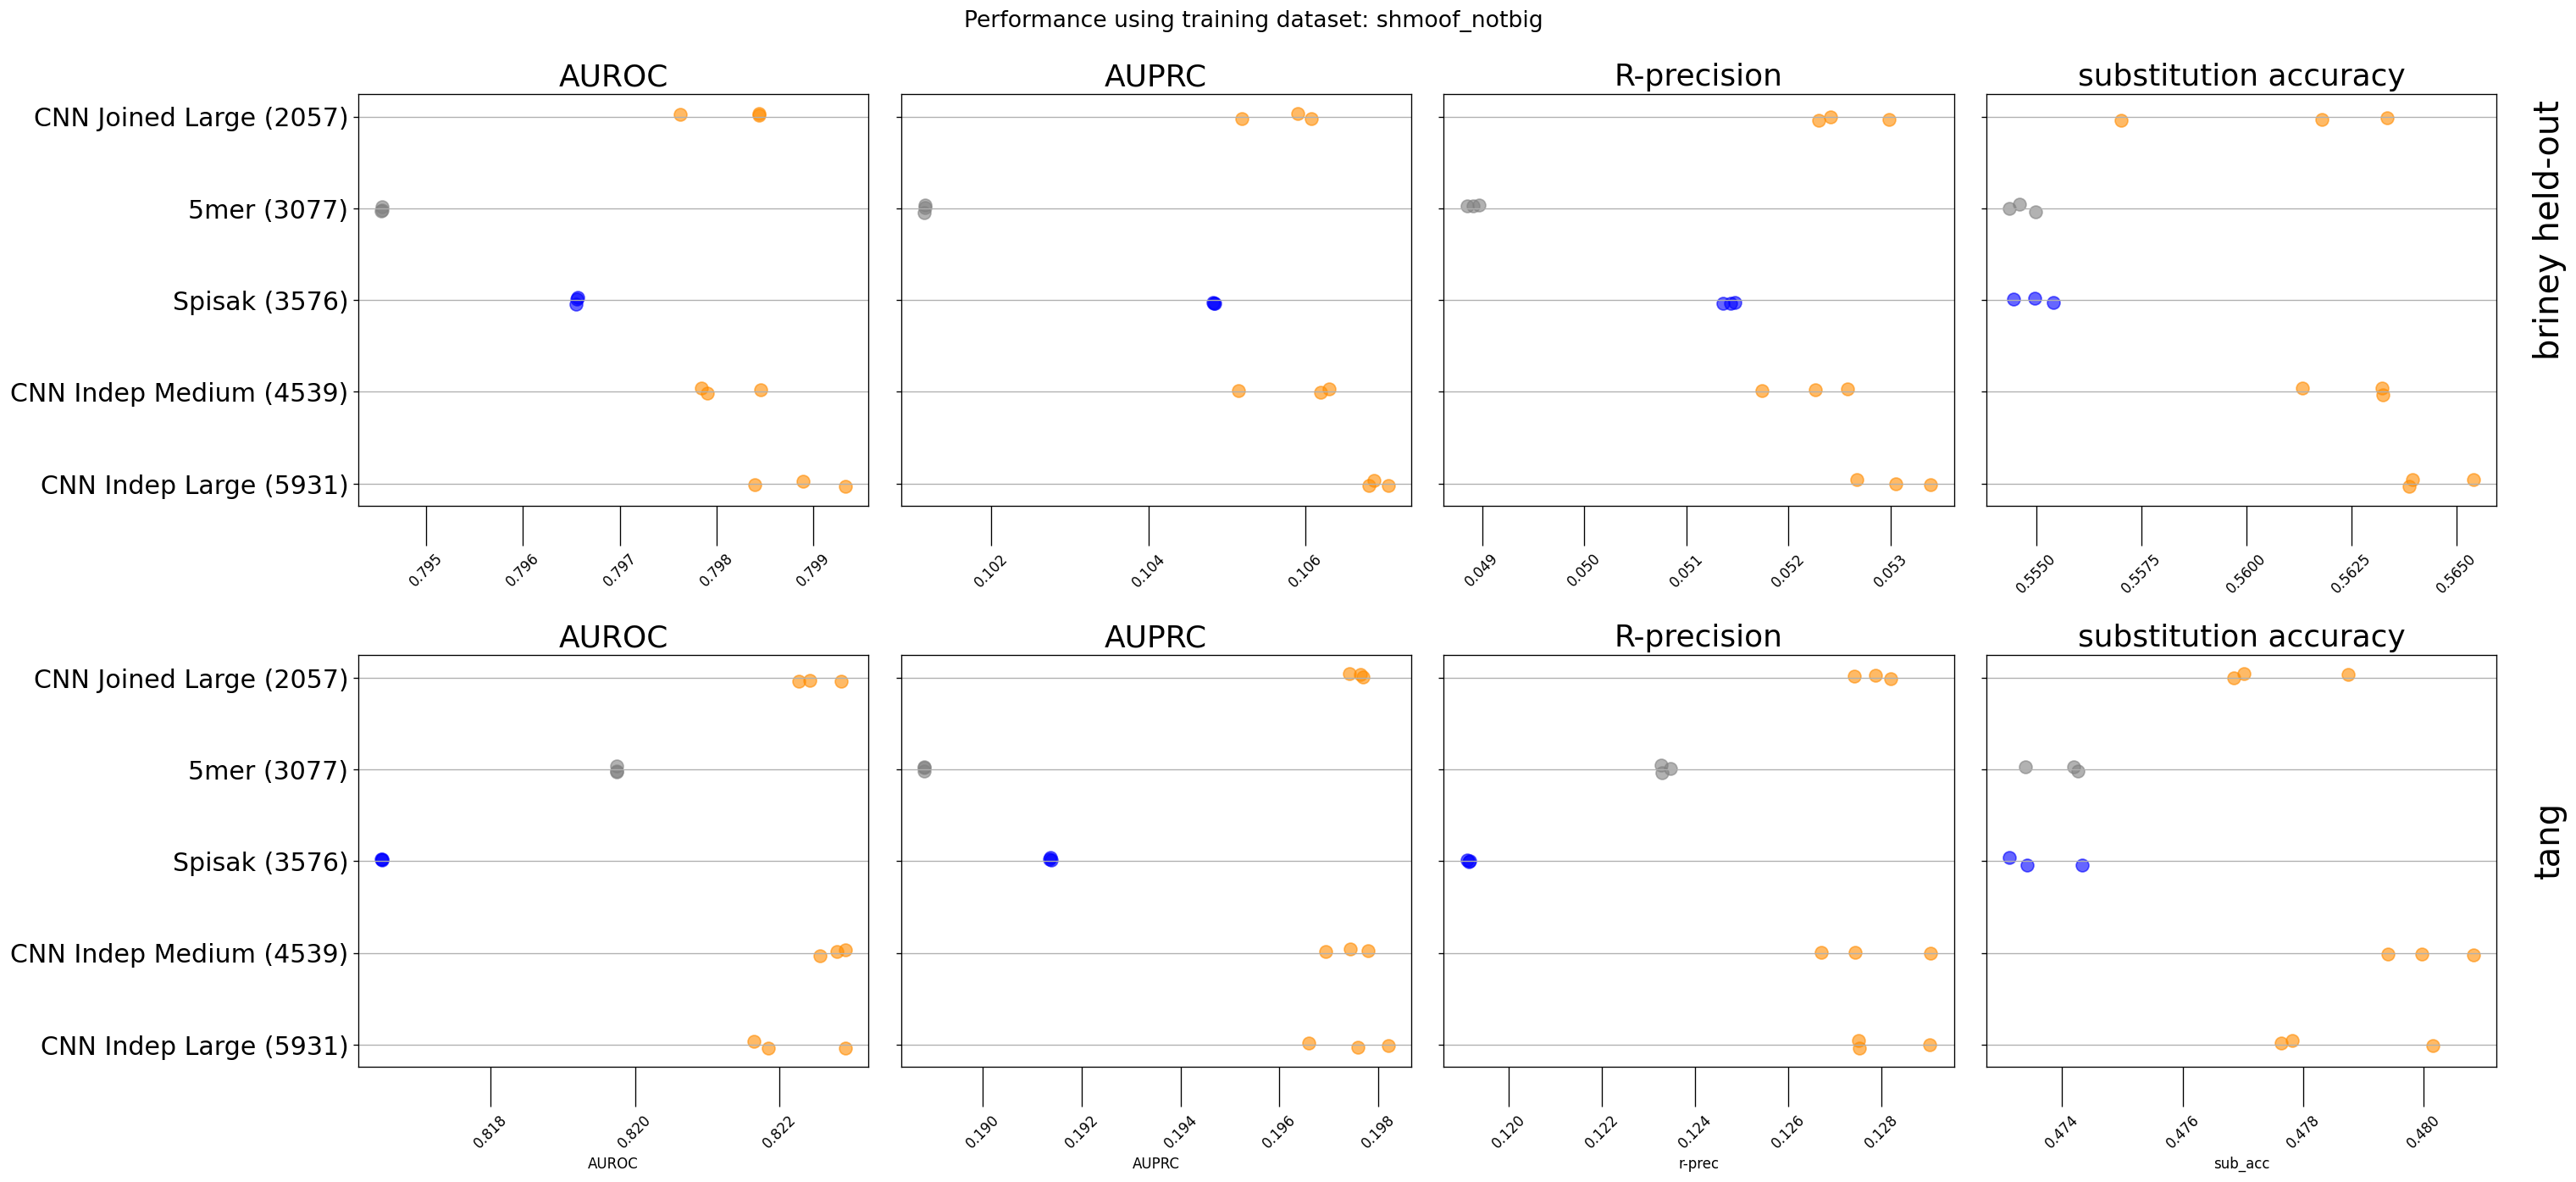

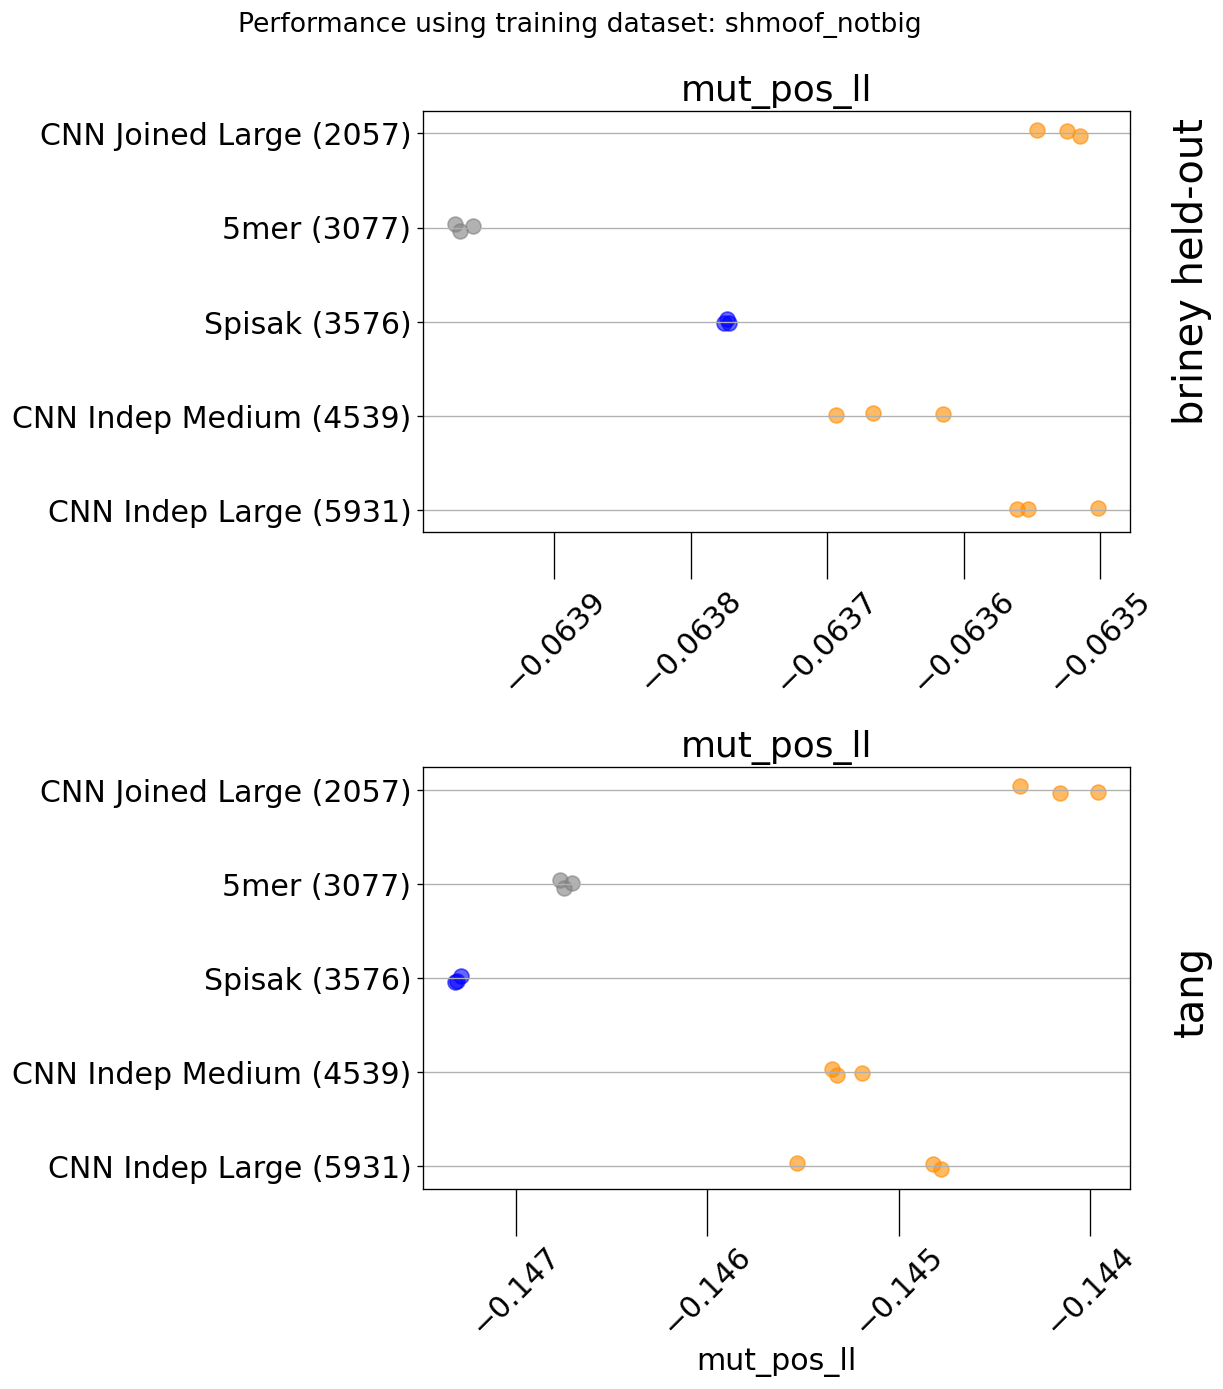

In [4]:
def plot_performance(df, train_dataset, test_datasets=None, filename=None, stats=None, include_reference=False, include_baseline=True):
    baseline_model = "s5f"
    reference_model = "cnn_ind_med-shmoof_small"
    df = df.copy()
    df = df[df["long_name"] != "Oracle"]
    df = df[df["model"] != "cnn_hyb_sml"]
    print(df.head())

    if train_dataset not in df['train dataset'].unique():
        raise ValueError(f"train dataset {train_dataset} not found in df")

    if stats is None:
        stats = ['AUROC', 'AUPRC', 'r-prec', 'sub_acc', 'overlap', 'mut_pos_ll']
    if test_datasets is None:
        test_datasets = df['test dataset'].unique()
    else:
        # check to make sure all test_datasets are in df
        for test_dataset in test_datasets:
            if test_dataset not in df['test dataset'].unique():
                raise ValueError(f"test dataset {test_dataset} not found in df")
    # # filter test_datasets to only include ones that end with _all
    # test_datasets = [x for x in test_datasets if x.endswith("_all")]
    unique_long_names = df['long_name'].unique()[::-1]
    name_to_y = {name: i for i, name in enumerate(unique_long_names)}

    # Setup figure parameters, transposing nrows with ncols
    nrows = len(test_datasets)
    ncols = len(stats)

    jitter_strength = 0.09

    # Loop through each training dataset to create separate figures or subplot grids
    # for train_dataset in train_datasets:
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols + 5, 6 * nrows), squeeze=False, sharey=True)
    # set font size for fig
    plt.rcParams.update({'font.size': 18})
    if len(df['train dataset'].unique()) > 1:
        fig.suptitle(f'Performance using training dataset: {train_dataset}', fontsize=16)

    for row_idx, test_dataset in enumerate(test_datasets):
        # Add test dataset name to the left of the row.
        test_dataset_name = test_dataset_mapping.get(test_dataset, test_dataset)
        fig.text(1.01, (nrows - row_idx - 0.4) / nrows, test_dataset_name, ha='center', va='center', rotation='vertical', fontsize=24)

        # Filter the DataFrame for models trained on `train_dataset` and tested on `test_dataset`
        df_filtered = df[(df['train dataset'] == train_dataset) & (df['test dataset'] == test_dataset)].copy()

        baseline_values = fixed_df.query("dataset_name == @test_dataset and crepe_basename == @baseline_model").reset_index(drop=True).iloc[0]
        reference_values = fixed_df.query("dataset_name == @test_dataset and crepe_basename == @reference_model").reset_index(drop=True).iloc[0]

        for col_idx, stat in enumerate(stats):
            if not df_filtered.empty:
                df_filtered[stat + '_relative'] = df_filtered[stat] - baseline_values[stat]
                df_filtered = df_filtered.sort_values(by="parameter_count", ascending=False)

                ax = axes[row_idx, col_idx]

                # Plot each point, adding jitter around the assigned y-value
                for i, row in df_filtered.iterrows():
                    y_pos = name_to_y[row['long_name']] + (np.random.rand() - 0.5) * jitter_strength
                    if row["model"][:3] == "cnn":
                        color = "darkorange"
                    elif row["model"] == "rsshmoof":
                        color = "blue"
                    else:
                        color = "gray"
                    ax.scatter(row[stat], y_pos, color=color, alpha=0.6, s=80)
                    print(row['long_name'])

                if include_baseline:
                    ax.axvline(x=baseline_values[stat], color='k')
                if include_reference:
                    ax.axvline(x=reference_values[stat], color='purple')

                ax.yaxis.grid(True, which='major')
                ax.set_yticks(np.arange(len(unique_long_names)))
                ax.set_yticklabels(unique_long_names, fontsize=18)
                ax.set_title(f"{stat_renaming_dict.get(stat, stat)}")
                #ax.set_title(f"{stat} on {test_dataset}")
                ax.tick_params(axis='x', rotation=45, size=28)
                if row_idx == nrows - 1:  # Only set x-labels for the bottom row
                    ax.set_xlabel(f'{stat}')
    fig.tight_layout()
    if filename is None:
        filename = f"performance_train_{train_dataset}" 
    fig.savefig(os.path.join(figures_dir, f"{filename}.svg"))

# print(df["train dataset"].unique())
# print(df["test dataset"].unique())

prediction_stats = ['AUROC', 'AUPRC', 'r-prec', 'sub_acc']
fit_stats = ['mut_pos_ll']

plot_performance(df, train_dataset='shmoof_notbig', stats=prediction_stats, include_baseline=False, filename="performance_train_shmoof_notbig_prediction")
plot_performance(df, train_dataset='shmoof_notbig', stats=fit_stats, include_baseline=False, filename="performance_train_shmoof_notbig_fit")
#plot_performance(df, train_dataset='shmoof_small', test_datasets=["shmoof_notbig_all","shmoof_small_all","val_tangshm_all"])
#plot_performance(df, train_dataset='shmoof_small', test_datasets=["val_syn10x25k_all"], filename="performance_train_shmoof_small_ON_syn10x25k")
#plot_performance(df, train_dataset='shmoof_small+syn10x', test_datasets=["val_tangshm_all"])

    parameter_count       test dataset     AUROC     AUPRC    r-prec  \
12             2057  shmoof_notbig_all  0.798433  0.105183  0.052986   
14             2057  shmoof_notbig_all  0.797626  0.106075  0.052411   
16             2057  shmoof_notbig_all  0.798439  0.105902  0.052298   
42             2057  shmoof_notbig_all  0.796044  0.103939  0.050989   
44             2057  shmoof_notbig_all  0.795528  0.103282  0.050390   

    mut_pos_ll   sub_acc   base_ll   overlap  residual        model  \
12   -0.063515  0.557017 -0.957153  0.939033  0.017466  cnn_joi_lrg   
14   -0.063546  0.561805 -0.954520  0.935185  0.018836  cnn_joi_lrg   
16   -0.063524  0.563357 -0.955461  0.936581  0.018223  cnn_joi_lrg   
42   -0.063754  0.544390 -0.975755  0.941614  0.016911  cnn_joi_lrg   
44   -0.063868  0.549178 -0.975363  0.941322  0.016776  cnn_joi_lrg   

           train dataset training method seed                long_name  
12         shmoof_notbig          simple    0  CNN Joined Large (20

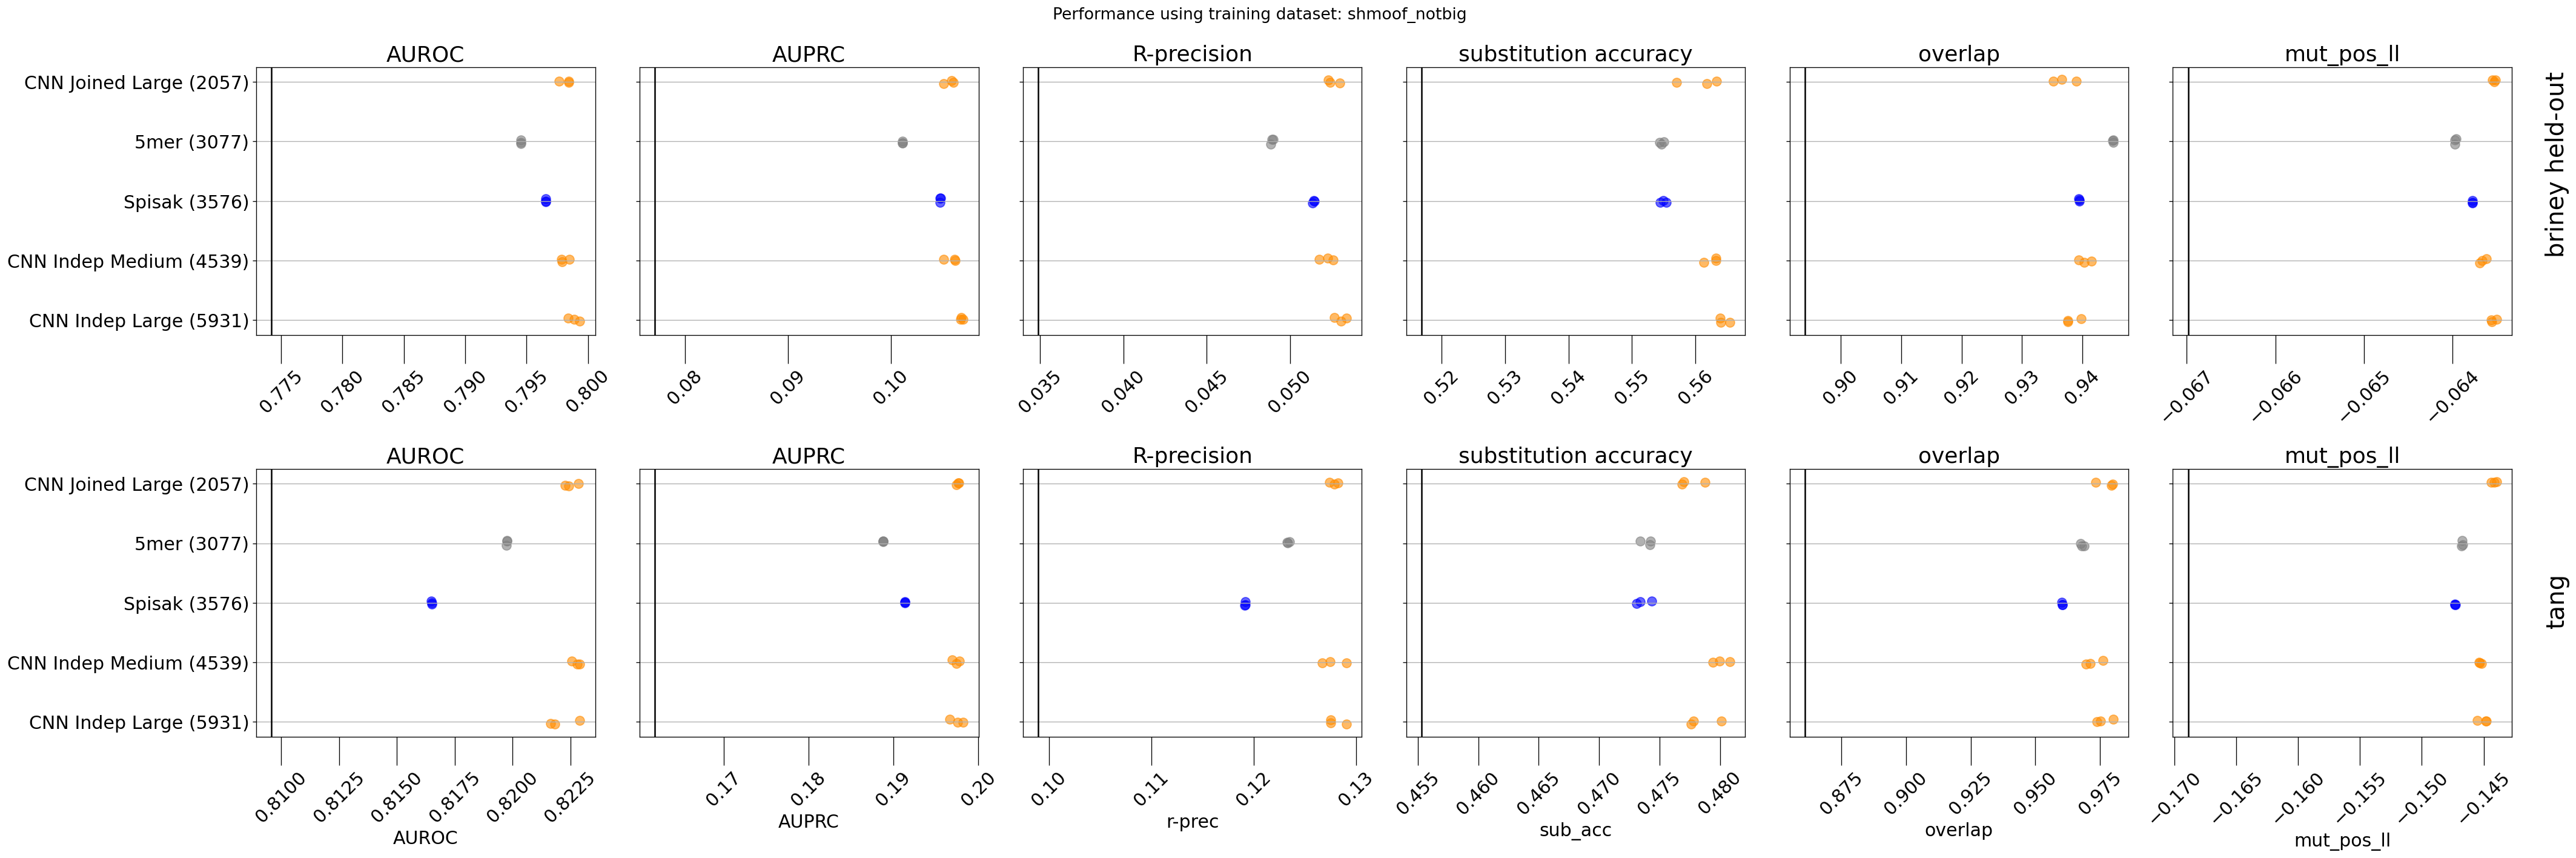

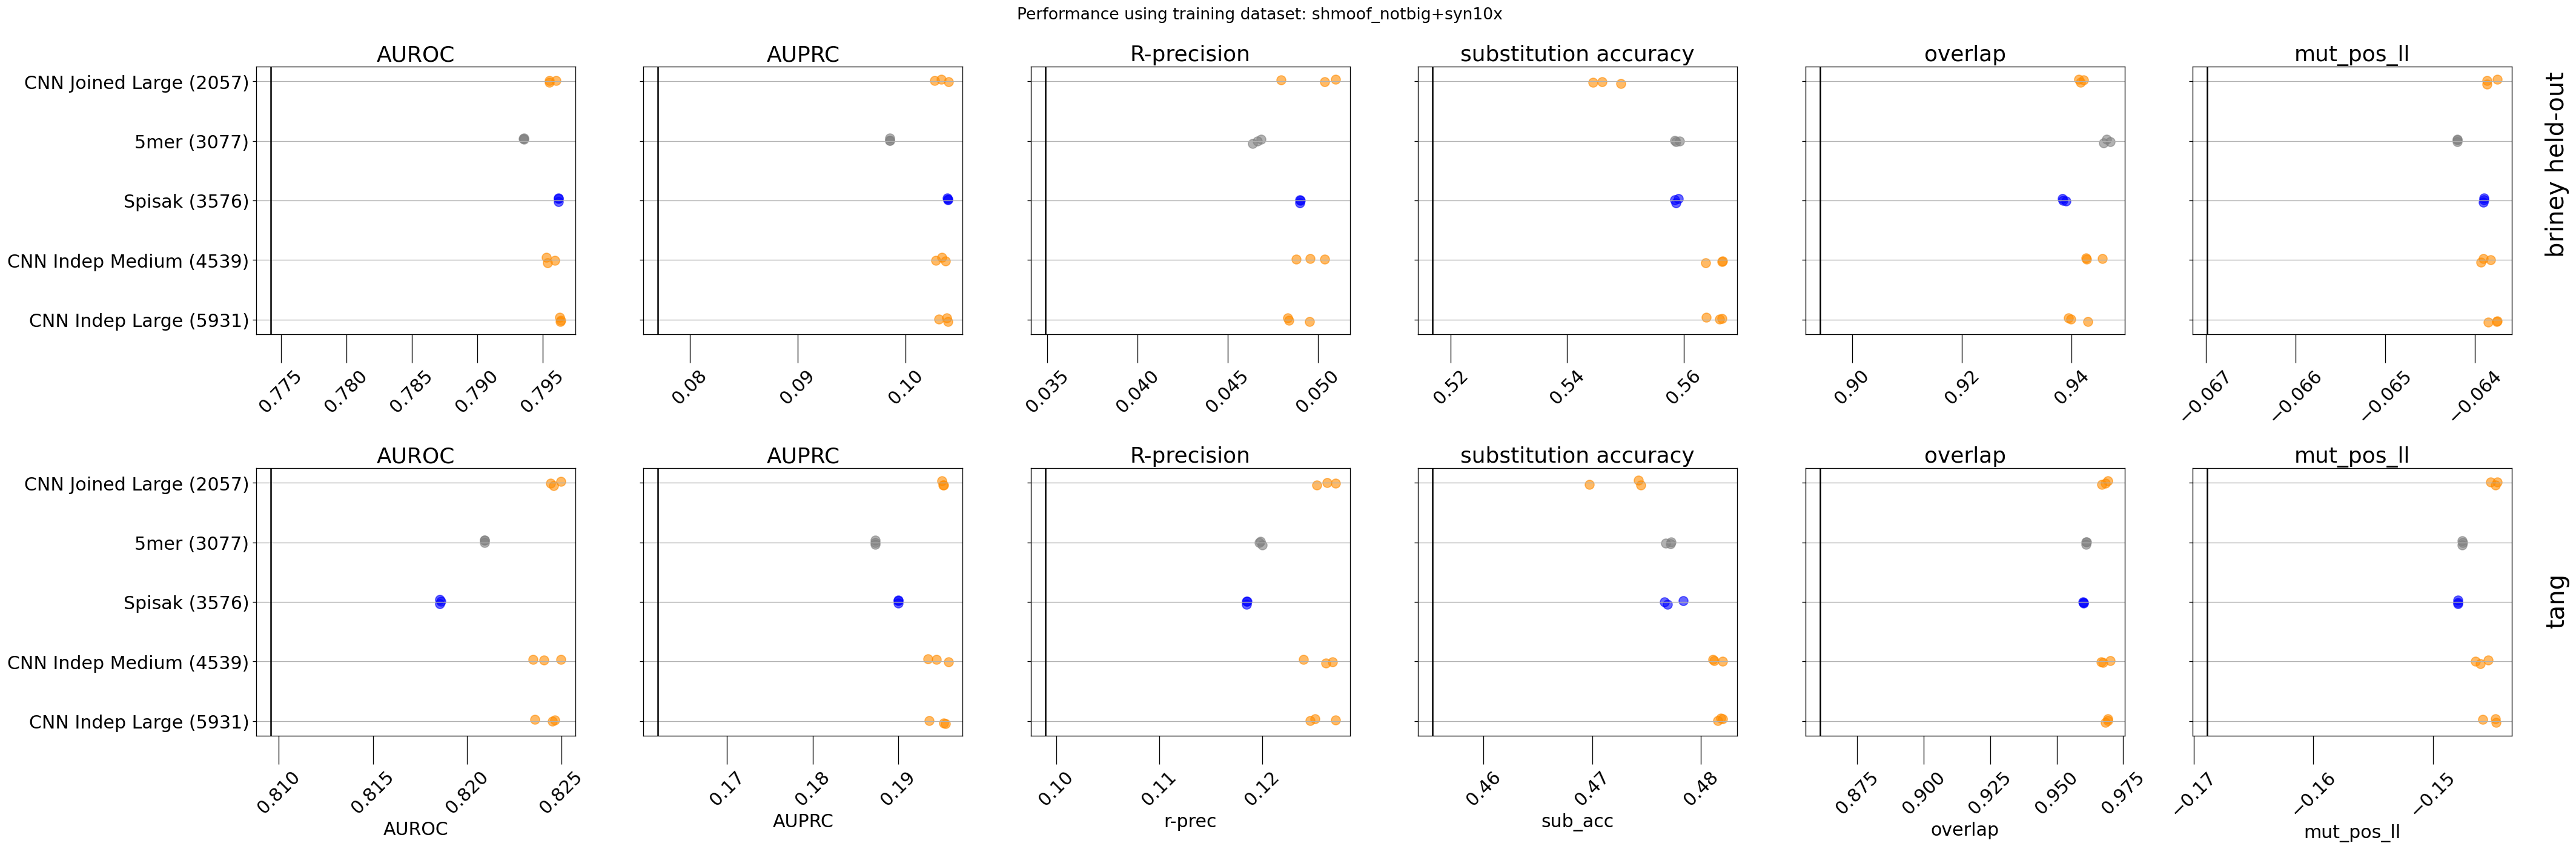

In [5]:
for train_dataset in df["train dataset"].unique():
    plot_performance(df, train_dataset=train_dataset)

In [8]:
grouped_by_training = df.groupby("train dataset")

data_columns = ["AUROC", "AUPRC", "r-prec", "sub_acc"]
label_columns = ["model", "seed", "long_name"]
useful_columns = data_columns + label_columns

grouped_by_training.get_group("shmoof_notbig+syn10x")
#i want to subtract data_columns in grouped_by_training.get_group("shmoof_notbig+syn10x") from those in grouped_by_training.get_group("shmoof_notbig") but preserve the label_columns

,AUROC,AUPRC,r-prec,sub_acc,model,seed,long_name
42,0.796044,0.103939,0.050989,0.544390,cnn_joi_lrg,0,CNN Joined Large (2057)
44,0.795528,0.103282,0.050390,0.549178,cnn_joi_lrg,1,CNN Joined Large (2057)
46,0.795533,0.102694,0.047961,0.546048,cnn_joi_lrg,2,CNN Joined Large (2057)
48,0.793548,0.098509,0.046642,0.559358,fivemer,0,5mer (3077)
50,0.793555,0.098519,0.046848,0.558490,fivemer,1,5mer (3077)
52,0.793556,0.098516,0.046370,0.558674,fivemer,2,5mer (3077)
54,0.796215,0.103885,0.048997,0.558674,rsshmoof,0,Spisak (3576)
56,0.796222,0.103881,0.049045,0.559121,rsshmoof,1,Spisak (3576)
58,0.796215,0.103885,0.048992,0.558464,rsshmoof,2,Spisak (3576)
36,0.795286,0.103702,0.050399,0.566750,cnn_ind_med,0,CNN Indep Medium (4539)


In [10]:
# print pandas version
print(pd.__version__)

2.2.2


In [11]:
# Extract the two groups
group_1 = grouped_by_training.get_group("shmoof_notbig").set_index(label_columns)
group_2 = grouped_by_training.get_group("shmoof_notbig+syn10x").set_index(label_columns)

# Ensure both groups are aligned based on the label columns
aligned_group_1, aligned_group_2 = group_1.align(group_2)

# Subtract the data_columns while preserving the label_columns
difference = aligned_group_2[data_columns] - aligned_group_1[data_columns]

# Reset the index to bring label_columns back as regular columns
difference = difference.reset_index()


          model seed                long_name     AUROC     AUPRC    r-prec  \
0   cnn_joi_lrg    0  CNN Joined Large (2057)  0.002389  0.001244  0.001997   
1   cnn_joi_lrg    1  CNN Joined Large (2057)  0.002098  0.002793  0.002021   
2   cnn_joi_lrg    2  CNN Joined Large (2057)  0.002906  0.003208  0.004337   
3       fivemer    0              5mer (3077)  0.000996  0.002641  0.002274   
4       fivemer    1              5mer (3077)  0.000986  0.002645  0.002003   
5       fivemer    2              5mer (3077)  0.000981  0.002647  0.002603   
6      rsshmoof    0            Spisak (3576)  0.000347  0.000961  0.002433   
7      rsshmoof    1            Spisak (3576)  0.000327  0.000938  0.002316   
8      rsshmoof    2            Spisak (3576)  0.000344  0.000942  0.002478   
9   cnn_ind_med    0  CNN Indep Medium (4539)  0.002552  0.002593  0.001860   
10  cnn_ind_med    1  CNN Indep Medium (4539)  0.001978  0.001815  0.002163   
11  cnn_ind_med    2  CNN Indep Medium (4539)  0.003